<a href="https://colab.research.google.com/github/Tristan-Brown1096/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [54]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [55]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [56]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [57]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [58]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [59]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [60]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Date            421 non-null    object 
 2   Yelp            87 non-null     float64
 3   Google          87 non-null     float64
 4   Chips           26 non-null     object 
 5   Cost            414 non-null    float64
 6   Hunger          418 non-null    float64
 7   Mass (g)        22 non-null     float64
 8   Density (g/mL)  22 non-null     float64
 9   Length          283 non-null    float64
 10  Circum          281 non-null    float64
 11  Volume          281 non-null    float64
 12  Tortilla        421 non-null    float64
 13  Temp            401 non-null    float64
 14  Meat            407 non-null    float64
 15  Fillings        418 non-null    float64
 16  Meat:filling    412 non-null    float64
 17  Uniformity      419 non-null    flo

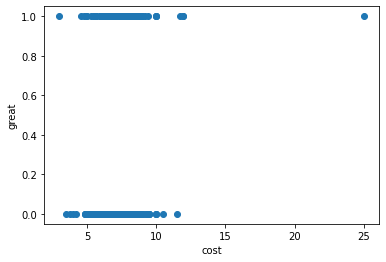

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.scatter(df['Cost'], df['Great'])

plt.xlabel('cost')
plt.ylabel('great')

fig.set_facecolor('w')

plt.show()

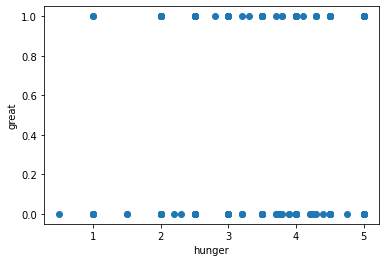

In [63]:
fig, ax = plt.subplots()

plt.scatter(df['Hunger'], df['Great'])

plt.xlabel('hunger')
plt.ylabel('great')

fig.set_facecolor('w')

plt.show()

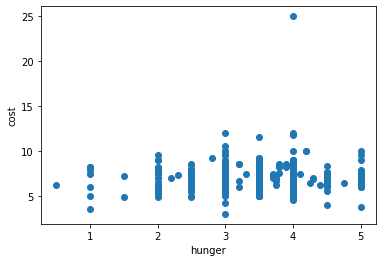

In [64]:
fig, ax = plt.subplots()

plt.scatter(df['Hunger'], df['Cost'])

plt.xlabel('hunger')
plt.ylabel('cost')

fig.set_facecolor('w')

plt.show()

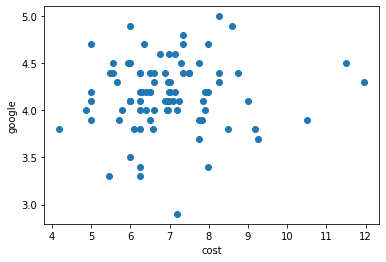

In [65]:
fig, ax = plt.subplots()

plt.scatter(df['Cost'], df['Google'])

plt.xlabel('cost')
plt.ylabel('google')

fig.set_facecolor('w')

plt.show()

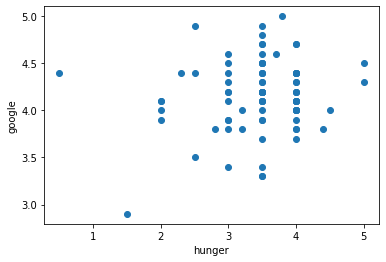

In [66]:
fig, ax = plt.subplots()

plt.scatter(df['Hunger'], df['Google'])

plt.xlabel('hunger')
plt.ylabel('google')

fig.set_facecolor('w')

plt.show()

#Train-Validation-Test split

In [67]:
#creating date-time variable to split data
df['Date'] = pd.to_datetime(df['Date'])

In [68]:
#creating dataframes based on time-series split
df_train = df[df['Date'].dt.year <= 2016]
df_val = df[df['Date'].dt.year == 2017]
df_test = df[df['Date'].dt.year >= 2018]

In [69]:
#sanity check
assert df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0]

In [70]:
#creating target vectors
y_train = df_train['Great']
y_val = df_val['Great']
y_test = df_test['Great']

#creating feature martrices
X_train = df_train.drop(['Great', 'Date'], axis=1)
X_val = df_val.drop(['Great', 'Date'], axis=1)
X_test = df_test.drop(['Great', 'Date'], axis=1)

#Establish baseline

In [71]:
print('Baseline accuracy score:', y_train.value_counts(normalize=True).max())

Baseline accuracy score: 0.5906040268456376


#Build Model

In [72]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder

model = Pipeline([
              ('encoder', OneHotEncoder()),
              ('imputer', SimpleImputer()),
              ('regressor', LogisticRegression())
])

model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('encoder',
                 OneHotEncoder(cols=['Burrito', 'Chips', 'Unreliable', 'NonSD',
                                     'Beef', 'Pico', 'Guac', 'Cheese', 'Fries',
                                     'Sour cream', 'Pork', 'Chicken', 'Shrimp',
                                     'Fish', 'Rice', 'Beans', 'Lettuce',
                                     'Tomato', 'Bell peper', 'Carrots',
                                     'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro',
                                     'Onion', 'Taquito', 'Pineapple', 'Ham',
                                     'Chile relleno', 'Nopales', ...],
                               drop_inv...
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('regressor',
                 LogisticRegression(C=1.0, class_weight=None, dual=False

#Check metrics

In [73]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9093959731543624
Validation Accuracy: 0.8117647058823529


#Change used data

In [74]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [75]:
X_train = df_train[['Burrito', 'Yelp', 'Google', 'Cost', 'Hunger', 'Tortilla',
                 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity',
                 'Salsa', 'Synergy', 'Wrap']]
X_val = df_val[['Burrito', 'Yelp', 'Google', 'Cost', 'Hunger', 'Tortilla',
                 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity',
                 'Salsa', 'Synergy', 'Wrap']]
X_test = df_test[['Burrito', 'Yelp', 'Google', 'Cost', 'Hunger', 'Tortilla',
                 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity',
                 'Salsa', 'Synergy', 'Wrap']]

#New model

In [76]:
model2 = Pipeline([
              ('encoder', OneHotEncoder()),
              ('imputer', SimpleImputer()),
              ('regressor', LogisticRegression())
])

model2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('encoder',
                 OneHotEncoder(cols=['Burrito'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('regressor',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
         

#Check metrics of new model

In [77]:
print('Training Accuracy:', model2.score(X_train, y_train))
print('Validation Accuracy:', model2.score(X_val, y_val))
print('Test Accuracy:', model2.score(X_test, y_test))

Training Accuracy: 0.8926174496644296
Validation Accuracy: 0.8470588235294118
Test Accuracy: 0.7894736842105263
